----
---
---
-----


## **7×7 bloklar feature map üzerinde rastgele konumlarda,her batch’te yeniden bazen ortada, bazen kenarda, bazen çaprazda uygulanır.**

----
---
---
-----


# DropBlock Schedule (Step / Batch Bazlı) — Mantık ve Hesaplama

Bu notebook, DropBlock içinde kullanılan **schedule** mantığını (özellikle `total_steps`, `step`, `t` ve `drop_prob`) netleştirir.  
Odak: **iteration/step (batch)** kavramı ve `total_steps` değerinin **nasıl belirlendiği**.


## 1) Terimler (en kısa tanım)

- **Dataset size (N)**: Toplam örnek sayısı (ör. 10.000 görüntü)
- **Batch size (B)**: Bir iterasyonda işlenen örnek sayısı (ör. 32)
- **Step / Iteration**: 1 batch işlendiğinde oluşan adım (genelde: forward + backward + optimizer update)
- **Epoch**: Dataset’in bir kez dolaşılması
- **Steps per epoch**: 1 epoch’ta kaç batch olduğu
- **Total training steps**: Tüm eğitim boyunca toplam kaç batch işlendiği
- **total_steps (schedule)**: DropBlock agresifliğinin 0’dan `max_drop_prob`’a kaç step’te ulaşacağı


## 2) Neden her şey batch/step üzerinden gidiyor?

Schedule, eğitim sürecini **zaman** (saniye/dakika) gibi değil, **kaç kez güncelleme yaptın** gibi düşünür.

Bu yüzden ana sayaç şudur:

- `step = 0, 1, 2, 3, ...`  (her batch’te +1)

Bu sayaç, `total_steps` ile oranlanır ve **0–1** arası bir ilerleme oranı üretilir:

- `t = clamp(step / total_steps, 0, 1)`

Sonra DropBlock şiddeti lineer artırılır:

- `drop_prob = max_drop_prob * t`


## 3) Örnek senaryo

- Toplam veri: **10.000**
- Batch size: **32**
- Epoch: **20**


In [1]:
import math

dataset_size = 10_000
batch_size   = 32
epochs       = 20

steps_per_epoch = math.ceil(dataset_size / batch_size)
total_training_steps = steps_per_epoch * epochs

steps_per_epoch, total_training_steps


(313, 6260)

Yorum:

- `steps_per_epoch = ceil(10000 / 32)` → **1 epoch’ta kaç batch olduğu**
- `total_training_steps = steps_per_epoch * epochs` → **tüm eğitim boyunca toplam kaç batch işlendiği**


## 4) `total_steps` nasıl seçilir?

`total_steps`, şu soruya cevap verir:

> DropBlock **kaç step sonra** maksimum şiddete (`max_drop_prob`) ulaşsın?

Pratik seçim yaklaşımı:
- Tüm eğitim boyunca yavaş artsın: `total_steps = total_training_steps`
- Eğitim süresinin %60’ında max’a gelsin: `total_steps = total_training_steps * 0.60`
- Eğitim süresinin %30’unda max’a gelsin: `total_steps = total_training_steps * 0.30`

Aşağıda bu seçenekleri hesaplayalım.


In [2]:
total_steps_all = total_training_steps
total_steps_60 = int(total_training_steps * 0.60)
total_steps_30 = int(total_training_steps * 0.30)

total_steps_all, total_steps_60, total_steps_30


(6260, 3756, 1878)

## 5) Schedule formülü (adım adım)

Aşağıdaki fonksiyon, schedule mantığının “hesap tarafını” gösterir:

- `t = clamp(step / total_steps, 0, 1)` → ilerleme oranı
- `drop_prob = max_drop_prob * t` → o anki DropBlock şiddeti

> Not: Bu `drop_prob`, “o batch’te kesin şu kadar alan düştü” demek değildir.  
> Bu değer, **blok merkezlerinin seçilme olasılığını** belirleyen hesaplara (ör. `gamma`) **girdi** olur.


In [3]:
def scheduled_drop_prob(step: int, total_steps: int, max_drop_prob: float):
    den = max(1, int(total_steps))     # 0 verilirse bölme patlamasın
    t = step / den                     # ilerleme oranı (clamp öncesi)
    t = min(max(t, 0.0), 1.0)          # clamp: 0 ile 1 arasında tut
    return max_drop_prob * t, t

max_drop_prob = 0.1

for s in [0, 1, 10, 100, 1000, total_steps_all//2, total_steps_all, total_steps_all + 500]:
    dp, t = scheduled_drop_prob(s, total_steps_all, max_drop_prob)
    print(f"step={s:6d} | t={t:6.4f} | drop_prob={dp:7.5f}")


step=     0 | t=0.0000 | drop_prob=0.00000
step=     1 | t=0.0002 | drop_prob=0.00002
step=    10 | t=0.0016 | drop_prob=0.00016
step=   100 | t=0.0160 | drop_prob=0.00160
step=  1000 | t=0.1597 | drop_prob=0.01597
step=  3130 | t=0.5000 | drop_prob=0.05000
step=  6260 | t=1.0000 | drop_prob=0.10000
step=  6760 | t=1.0000 | drop_prob=0.10000


## 6) Görsel sezgi: `drop_prob` nasıl artar?

Aşağıdaki grafik:
- X ekseni: step (kaç batch işlendi)
- Y ekseni: `drop_prob` (schedule sonucu)

`total_steps = total_training_steps` seçimiyle:
- eğitim başında düşük,
- eğitim ilerledikçe `max_drop_prob`’a yaklaşır,
- `step >= total_steps` olunca `max_drop_prob`’ta sabitlenir.


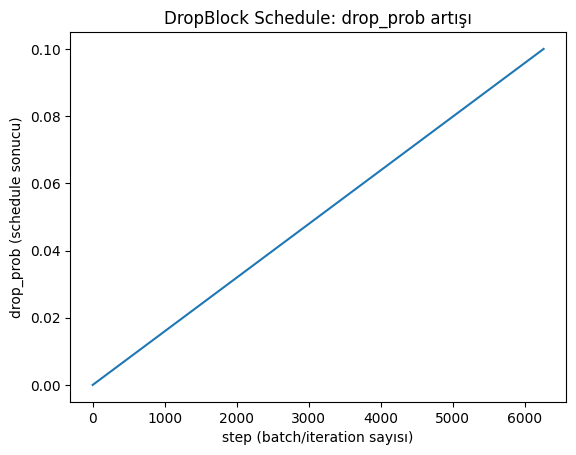

In [4]:
import numpy as np
import matplotlib.pyplot as plt

steps = np.arange(0, total_training_steps + 1)
drop_probs = np.array([scheduled_drop_prob(int(s), total_steps_all, max_drop_prob)[0] for s in steps])

plt.figure()
plt.plot(steps, drop_probs)
plt.xlabel("step (batch/iteration sayısı)")
plt.ylabel("drop_prob (schedule sonucu)")
plt.title("DropBlock Schedule: drop_prob artışı")
plt.show()


## 7) Kısa özet

- `step`: modelin şu ana kadar **kaç batch** işlediğini sayar (0,1,2,3,...).
- `total_training_steps`: tüm eğitim boyunca toplam batch sayısıdır.
- `total_steps` (schedule): DropBlock’un **kaç batch sonra** maksimum şiddete ulaşacağını belirler.
- `t = step / total_steps` → 0–1 arası “ilerleme oranı”.
- `drop_prob = max_drop_prob * t` → DropBlock’un o anki şiddeti.

Bu yapı sayesinde DropBlock:
- eğitim başında daha “hafif”,
- eğitim ilerledikçe daha “agresif” hale getirilebilir.
